## Compute lag features for gradient boosting model

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
colnames = ['id', 'ts', 'station_name', 'address', 'total_docks',
           'docks_in_service', 'available_docks', 'available_bikes',
           'percent_full', 'status', 'latitude', 'longitude', 'location', 'record']
docks_df = pd.read_csv('/Users/jordi/Downloads/chicago_docks.csv', names=colnames)

In [3]:
# drop unnecessary columns
docks_df = docks_df.drop(columns=['location', 'record'])

In [4]:
docks_df.head()

,id,ts,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,longitude
0,2,10/26/2018 11:55:13 AM,Buckingham Fountain,Buckingham Fountain,39,39,36,3,8,In Service,41.876470,-87.620340
1,3,10/26/2018 11:55:13 AM,Shedd Aquarium,Shedd Aquarium,55,54,50,4,7,In Service,41.867226,-87.615355
2,4,10/26/2018 11:55:13 AM,Burnham Harbor,Burnham Harbor,23,23,9,14,61,In Service,41.856268,-87.613348
3,5,10/26/2018 11:55:13 AM,State St & Harrison St,State St & Harrison St,23,22,20,2,9,In Service,41.874053,-87.627716
4,6,10/26/2018 11:55:13 AM,Dusable Harbor,Dusable Harbor,39,38,32,6,16,In Service,41.886976,-87.612813


In [5]:
docks_df.id.unique().shape

(615,)

In [6]:
stations_df = pd.read_csv('./datasets/chicago_stations.csv')

In [7]:
stations_df.head()

,Unnamed: 0,id,station_name,address,lat,lon
0,0,2,Buckingham Fountain,Buckingham Fountain,41.876470,-87.620340
1,1,3,Shedd Aquarium,Shedd Aquarium,41.867226,-87.615355
2,2,4,Burnham Harbor,Burnham Harbor,41.856268,-87.613348
3,3,5,State St & Harrison St,State St & Harrison St,41.874053,-87.627716
4,4,6,Dusable Harbor,Dusable Harbor,41.886976,-87.612813


In [8]:
stations_df.id.unique().shape

(615,)

In [9]:
station_ids = stations_df.id.unique()

## Preprocess at station level

In [10]:
station_id = 463
df = docks_df[docks_df.id == station_id]
df['ts'] = pd.to_datetime(df.ts, infer_datetime_format=True)

In [11]:
df.ts.min(), df.ts.max()

(Timestamp('2017-01-01 00:05:11'), Timestamp('2018-10-26 11:55:13'))

In [12]:
# round ts every 5 minutes (seconds are not aligned)
df.loc[:, 'ts'] = df.ts.dt.round('5min')
df.sort_values(by='ts', inplace=True)

In [13]:
# resample data, there are missing info gaps
df = df.set_index('ts').resample('10Min', how='last', base=5).bfill()

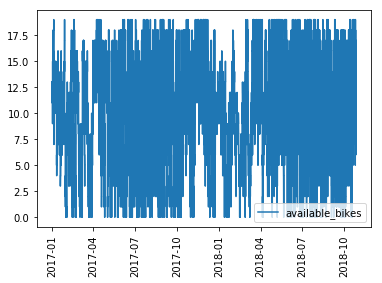

In [14]:
plt.plot(df.index, df.available_bikes, label='available_bikes')
plt.xticks(rotation=90)
plt.legend()

In [15]:
# every hour we have 6 rows, one every 10 minutes
entries_per_hour = 6

In [16]:
# month of year
df['month'] = df.index.month
# quarter of year
df['quarter'] = df.index.quarter
# day of month
df['day'] = df.index.day
# hour of day
df['hour'] = df.index.hour
# cyclic features for hour
df['hour_x'] = np.sin(2*np.pi*df['hour']/24)
df['hour_y'] = np.cos(2*np.pi*df['hour']/24)
# quarter of hour
df['quarter_hour'] = np.floor(df.index.minute / 15)
# day of week
df['dow'] = df.index.dayofweek
# week of year
df['week'] = df.index.weekofyear

In [17]:
ab_daily_mean = df.groupby('day')['available_bikes'].mean()
ab_monthly_mean = df.groupby('month')['available_bikes'].mean()
ab_weekly_mean = df.groupby('week')['available_bikes'].mean()

ab_daily_median = df.groupby('day')['available_bikes'].median()
ab_monthly_median = df.groupby('month')['available_bikes'].median()
ab_weekly_median = df.groupby('week')['available_bikes'].median()

In [18]:
for i, x in zip(ab_daily_mean.index, ab_daily_mean):
    df.loc[df.day == i, 'ab_daily_mean'] = x
    
for i, x in zip(ab_monthly_mean.index, ab_monthly_mean):
    df.loc[df.month == i, 'ab_monthly_mean'] = x
    
for i, x in zip(ab_weekly_mean.index, ab_weekly_mean):
    df.loc[df.week == i, 'ab_weekly_mean'] = x
    
for i, x in zip(ab_daily_median.index, ab_daily_median):
    df.loc[df.day == i, 'ab_daily_median'] = x
    
for i, x in zip(ab_monthly_median.index, ab_monthly_median):
    df.loc[df.month == i, 'ab_monthly_median'] = x
    
for i, x in zip(ab_weekly_median.index, ab_weekly_median):
    df.loc[df.week == i, 'ab_weekly_median'] = x

In [19]:
last_1w_hourly_mean = df.shift(entries_per_hour*24*7 - entries_per_hour)['available_bikes'].rolling(entries_per_hour).mean()
last_1w_daily_mean = df.shift(entries_per_hour*24*7 - entries_per_hour*24)['available_bikes'].rolling(entries_per_hour*24).mean()
last_2w_hourly_mean = df.shift(entries_per_hour*24*7*2 - entries_per_hour)['available_bikes'].rolling(entries_per_hour).mean()
last_2w_daily_mean = df.shift(entries_per_hour*24*7*2 - entries_per_hour*24)['available_bikes'].rolling(entries_per_hour*24).mean()

In [20]:
df['last_1w_hourly_mean'] = last_1w_hourly_mean
df['last_1w_daily_mean'] = last_1w_daily_mean
df['last_2w_hourly_mean'] = last_2w_hourly_mean
df['last_2w_daily_mean'] = last_2w_daily_mean

In [21]:
# set status to unknown when status is not available
df.loc[pd.isna(df.status), 'status'] = 'Unknown'

In [22]:
df.columns

Index(['id', 'station_name', 'address', 'total_docks', 'docks_in_service',
       'available_docks', 'available_bikes', 'percent_full', 'status',
       'latitude', 'longitude', 'month', 'quarter', 'day', 'hour', 'hour_x',
       'hour_y', 'quarter_hour', 'dow', 'week', 'ab_daily_mean',
       'ab_monthly_mean', 'ab_weekly_mean', 'ab_daily_median',
       'ab_monthly_median', 'ab_weekly_median', 'last_1w_hourly_mean',
       'last_1w_daily_mean', 'last_2w_hourly_mean', 'last_2w_daily_mean'],
      dtype='object')

### Set train/test splits

In [23]:
train_df = df.query('20170101 <= ts < 20180928')
# 2 weeks for validation
val_df = df.query('20180928 <= ts < 20181012')
# 2 weeks for test
test_df = df.query('ts >= 20181012')

In [24]:
train_df.shape, val_df.shape, test_df.shape

((91440, 30), (2016, 30), (2088, 30))

In [25]:
# overwrite last_1w_hourly_mean, last_1w_daily_mean columns for the second test week 
# this info is not available at test time!
idx = test_df.shift(freq=datetime.timedelta(weeks=1))[:entries_per_hour*24*7].index
features = ['last_1w_hourly_mean', 'last_1w_daily_mean']
test_df.loc[idx, features] = test_df.loc[idx - datetime.timedelta(weeks=1), features]

In [26]:
# drop first 2 weeks in train, no info for last_1w/2w features
train_df = train_df.iloc[entries_per_hour*24*7*2:]

In [27]:
train_df.shape, val_df.shape, test_df.shape

((89424, 30), (2016, 30), (2088, 30))

In [28]:
train_df.index.min(), train_df.index.max(), val_df.index.min(), val_df.index.max(), test_df.index.min(), test_df.index.max()

(Timestamp('2017-01-15 00:05:00', freq='10T'),
 Timestamp('2018-09-27 23:55:00', freq='10T'),
 Timestamp('2018-09-28 00:05:00', freq='10T'),
 Timestamp('2018-10-11 23:55:00', freq='10T'),
 Timestamp('2018-10-12 00:05:00', freq='10T'),
 Timestamp('2018-10-26 11:55:00', freq='10T'))

In [29]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

xs_features = ['total_docks', 'docks_in_service', 'status', 'ab_daily_mean', 'ab_monthly_mean', 'ab_weekly_mean',
               'ab_daily_median', 'ab_monthly_median', 'ab_weekly_median', 'hour_x', 'hour_y',
              'month', 'quarter', 'day', 'hour', 'quarter_hour', 'dow', 'week', 'last_1w_hourly_mean',
              'last_1w_daily_mean', 'last_2w_hourly_mean', 'last_2w_daily_mean']
target = ['available_bikes']

le = LabelEncoder()
train_df['status'] = le.fit_transform(train_df['status'])
val_df['status'] = le.transform(val_df['status'])
test_df['status'] = le.transform(test_df['status'])

train_data = lgb.Dataset(train_df[xs_features], label=train_df[target],
                        feature_name=xs_features, categorical_feature=['status'])
val_data = lgb.Dataset(val_df[xs_features], label=val_df[target],
                      feature_name=xs_features, categorical_feature=['status'], reference=train_data)
test_data = lgb.Dataset(test_df[xs_features], label=test_df[target],
                       feature_name=xs_features, categorical_feature=['status'])

In [30]:
test_df.head()

,id,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,...,ab_daily_mean,ab_monthly_mean,ab_weekly_mean,ab_daily_median,ab_monthly_median,ab_weekly_median,last_1w_hourly_mean,last_1w_daily_mean,last_2w_hourly_mean,last_2w_daily_mean
ts,,,,,,,,,,,,,,,,,,,,,
2018-10-12 00:05:00,463.0,Clark St & Berwyn Ave,Clark St & Berwyn Ave,19.0,18.0,4.0,14.0,78.0,0,41.977997,...,10.988636,11.230826,11.563988,11.0,12.0,13.0,15.166667,13.013889,13.833333,10.104167
2018-10-12 00:15:00,463.0,Clark St & Berwyn Ave,Clark St & Berwyn Ave,19.0,18.0,4.0,14.0,78.0,0,41.977997,...,10.988636,11.230826,11.563988,11.0,12.0,13.0,15.000000,13.020833,14.000000,10.104167
2018-10-12 00:25:00,463.0,Clark St & Berwyn Ave,Clark St & Berwyn Ave,19.0,18.0,4.0,14.0,78.0,0,41.977997,...,10.988636,11.230826,11.563988,11.0,12.0,13.0,15.000000,13.034722,14.000000,10.097222
2018-10-12 00:35:00,463.0,Clark St & Berwyn Ave,Clark St & Berwyn Ave,19.0,18.0,4.0,14.0,78.0,0,41.977997,...,10.988636,11.230826,11.563988,11.0,12.0,13.0,15.000000,13.048611,14.000000,10.090278
2018-10-12 00:45:00,463.0,Clark St & Berwyn Ave,Clark St & Berwyn Ave,19.0,18.0,4.0,14.0,78.0,0,41.977997,...,10.988636,11.230826,11.563988,11.0,12.0,13.0,15.000000,13.062500,14.000000,10.083333


In [31]:
params = {
    'objective': 'regression_l2',
    'num_threds': 4,
    'max_depth': 5,
    'num_boost_rounds': 100,
    'bagging_fraction': 0.75,
    'bagging_freq': 3,
    'feature_fraction': 0.75
}
bst = lgb.train(params, train_data, valid_sets=[val_data, test_data], early_stopping_rounds=10)

[1]	valid_0's l2: 25.3263	valid_1's l2: 29.8959
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 24.5471	valid_1's l2: 29.2504
[3]	valid_0's l2: 23.8154	valid_1's l2: 29.6783
[4]	valid_0's l2: 23.6718	valid_1's l2: 29.6436
[5]	valid_0's l2: 22.83	valid_1's l2: 28.3744
[6]	valid_0's l2: 22.1759	valid_1's l2: 27.7469
[7]	valid_0's l2: 21.8755	valid_1's l2: 26.7705
[8]	valid_0's l2: 21.8429	valid_1's l2: 26.1286
[9]	valid_0's l2: 21.5248	valid_1's l2: 25.738
[10]	valid_0's l2: 21.4599	valid_1's l2: 25.3751
[11]	valid_0's l2: 21.4931	valid_1's l2: 24.9782
[12]	valid_0's l2: 21.0846	valid_1's l2: 24.7012
[13]	valid_0's l2: 21.0439	valid_1's l2: 24.6882
[14]	valid_0's l2: 21.1397	valid_1's l2: 24.7352
[15]	valid_0's l2: 20.984	valid_1's l2: 24.9671
[16]	valid_0's l2: 20.9199	valid_1's l2: 24.7502
[17]	valid_0's l2: 20.8574	valid_1's l2: 24.5687
[18]	valid_0's l2: 20.886	valid_1's l2: 24.5223
[19]	valid_0's l2: 20.6568	valid_1's l2: 24.8519
[20]	valid_0's l2: 21

In [32]:
y_true = test_df['available_bikes']
y_hat = bst.predict(test_df[xs_features], num_iteration=bst.best_iteration)

In [33]:
# rmse
np.sqrt(np.mean((y_true - y_hat)**2))

4.951996783134713

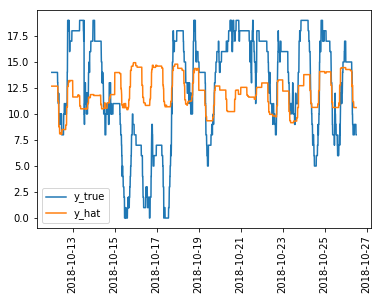

In [34]:
plt.plot(test_df.index, y_true, label='y_true')
plt.plot(test_df.index, y_hat, label='y_hat')
plt.xticks(rotation=90)
plt.legend()

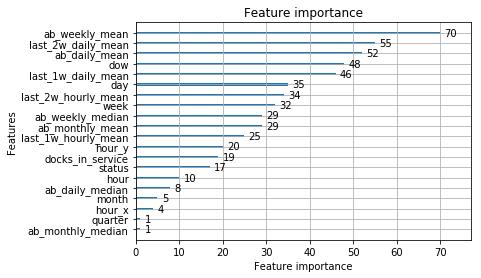

In [35]:
# plot feature importance
lgb.plot_importance(bst)

In [38]:
results = pd.DataFrame({'date': test_df.index, 'y_hat': y_hat, 'y_true': y_true})
results.set_index('date', inplace=True)
results.head()

,y_hat,y_true
date,,
2018-10-12 00:05:00,12.676925,14.0
2018-10-12 00:15:00,12.676925,14.0
2018-10-12 00:25:00,12.676925,14.0
2018-10-12 00:35:00,12.676925,14.0
2018-10-12 00:45:00,12.676925,14.0


# Bayesian optimization with scikit-optimize

In [39]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

/Users/jordi/.pyenv/versions/3.6.5/envs/master/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [63]:
ITERATIONS = 10

# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMRegressor(
        random_state=42
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'bagging_fraction': (0.01, 1.0, 'uniform'),
        'feature_fraction': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (100, 1000)
    },
    cv = StratifiedKFold(
        n_splits=2,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 4,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

# Fit the model
result = bayes_cv_tuner.fit(pd.concat((train_df, val_df))[xs_features], pd.concat((train_df, val_df))[target])

In [64]:
y_hat = result.predict(test_df[xs_features])
# rmse
np.sqrt(np.mean((y_true - y_hat)**2))

5.648027744182841

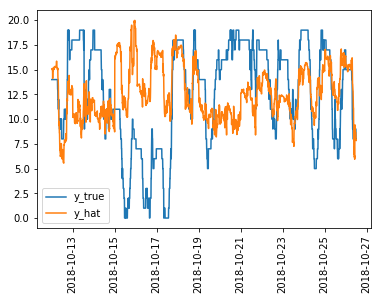

In [65]:
plt.plot(test_df.index, y_true, label='y_true')
plt.plot(test_df.index, y_hat, label='y_hat')
plt.xticks(rotation=90)
plt.legend()